# 데이터셋 설명 & 사용 방법 링크
### https://www.cs.toronto.edu/~kriz/cifar.html


# 데이터 살펴보기

In [8]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [24]:
base_path = "D:/NoShare/CIFAR10/cifar-10-batches-py/"
tmp = unpickle(base_path + "data_batch_1")

In [10]:
tmp.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [11]:
# 각 픽셀의 값으로 0 ~ 255 이다.
# 255로 나눠주면 Nomalize 해주는 효과가 있다. (0~1 사이의 값으로 만들어줌)
tmp[b'data']

array([[ 59,  43,  50, ..., 140,  84,  72],
       [154, 126, 105, ..., 139, 142, 144],
       [255, 253, 253, ...,  83,  83,  84],
       ...,
       [ 71,  60,  74, ...,  68,  69,  68],
       [250, 254, 211, ..., 215, 255, 254],
       [ 62,  61,  60, ..., 130, 130, 131]], dtype=uint8)

In [12]:
tmp[b'data'].shape

(10000, 3072)

# 데이터를 읽어서 Image, Label로 분리 및 학습, 검증, 테스트 용으로 분리

In [16]:
def pickle_to_images_and_labels(path):
    data = unpickle(path)
    # Nomalize
    data_images = data[b'data'] / 255 
    # Shape을 사진 형태로 만들어줌
    data_images = data_images.reshape(-1, 3, 32, 32).astype("float32")
    data_labels = data[b'labels']
    return data_images, data_labels

In [21]:
# 이미지, 라벨 불러오기
images1, labels1 = pickle_to_images_and_labels(base_path + "data_batch_1")
images2, labels2 = pickle_to_images_and_labels(base_path + "data_batch_2")
images3, labels3 = pickle_to_images_and_labels(base_path + "data_batch_3")
images4, labels4 = pickle_to_images_and_labels(base_path + "data_batch_4")
images5, labels5 = pickle_to_images_and_labels(base_path + "data_batch_5")

In [25]:
# Test 용 이미지, 라벨 불러오기
test_images, test_labels = pickle_to_images_and_labels(base_path + "test_batch") 

In [27]:
import numpy as np

# 5개의 데이터 배치를 합쳐서 학습 데이터셋 생성
train_images = np.concatenate([images1, images2, images3, images4, images5], axis=0)
train_labels = np.concatenate([labels1, labels2, labels3, labels4, labels5], axis=0)

# 따로 따로 처리했을 때 문제가 발생할 수 있으므로 같이 처리해준다.
test_images = np.concatenate([test_images], axis=0)
test_labels = np.concatenate([test_labels], axis=0)

In [33]:
from sklearn.model_selection import train_test_split

# 학습 이미지에서 Validation set 분리
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, 
    train_labels, 
    stratify=train_labels, 
    random_state=42, 
    test_size=0.2
)

In [37]:
print(f"학습 이미지   shape:\t{train_images.shape}")
print(f"학습 라벨     shape:\t{train_labels.shape}\n")

print(f"검증 이미지   shape:\t{valid_images.shape}")
print(f"검증 라벨     shape:\t{valid_labels.shape}\n")

print(f"테스트 이미지 shape:\t{test_images.shape}")
print(f"테스트 이미지 shape:\t{test_labels.shape}\n")

학습 이미지   shape:	(40000, 3, 32, 32)
학습 라벨     shape:	(40000,)

검증 이미지   shape:	(10000, 3, 32, 32)
검증 라벨     shape:	(10000,)

테스트 이미지 shape:	(10000, 3, 32, 32)
테스트 이미지 shape:	(10000,)



# Tensor 형식 데이터로 만들고 DataLoader 생성하기

In [39]:
import torch

from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_images_tensor = torch.tensor(train_images)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size=batch_size, num_workers=0, shuffle=True)

valid_images_tensor = torch.tensor(valid_images)
valid_labels_tensor = torch.tensor(valid_labels)
valid_tensor = TensorDataset(valid_images_tensor, valid_labels_tensor)
valid_loader = DataLoader(valid_tensor, batch_size=batch_size, num_workers=0, shuffle=True)

test_images_tensor = torch.tensor(test_images)

# CNN 모델 구성

In [42]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # input channels, output channels, stride
        # Color channel이 RGB로 3
        # padding을 1 추가 (기본이 0) -> 동일한 사이즈의 output이 나오도록 추가
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fc layer로 갈 때 flatten 진행
        # 64 -> 32 -> 10 은 임의의 숫자. 정해진 것이 없다.
        # conv -> pool -> 로 나온 사이즈 -> fc -> output
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = self.conv1(x)  # 32 * 32 * 3
        x = F.relu(x)      # 32 * 32 * 8
        x = self.pool(x)   # 16 * 16 * 8
        x = self.conv2(x)  # 16 * 16 * 16
        x = F.relu(x)      # 16 * 16 * 16
        x = self.pool(x)   # 8 * 8 * 16

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [43]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE

device(type='cuda')

In [44]:
model = CNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

# 앞서한 것과 동일한 학습 -> 평가 -> 예측결과 정확도 확인

In [60]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE, dtype=torch.int64)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

def evaluate(model, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(DEVICE), target.to(DEVICE, dtype=torch.int64)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    valid_accuracy = 100 * correct / len(valid_loader.dataset)
    return valid_loss, valid_accuracy

In [61]:
'''
TRAINING

이런 표시를 훈련 위에 둬서 시간이 오래 걸릴 수도 있으니
EPOCHS = 1로 둬서 위의 코드들을 검증하기도 함.
'''
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    train(epoch, model, train_loader, optimizer)
    valid_loss, valid_accuracy = evaluate(model, valid_loader)
    print(f"[EPOCH : {epoch}], \tValidation Loss: {valid_loss:.4f}, \tValidation Accuracy: {valid_accuracy:.2f} % \n")


Train Epoch: 1 [0/40000 (0%)]	Loss: 0.623523
Train Epoch: 1 [6400/40000 (16%)]	Loss: 0.964181
Train Epoch: 1 [12800/40000 (32%)]	Loss: 0.795917
Train Epoch: 1 [19200/40000 (48%)]	Loss: 1.011686
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.095633
Train Epoch: 1 [32000/40000 (80%)]	Loss: 0.745271
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.024399
[EPOCH : 1], 	Validation Loss: 1.0525, 	Validation Accuracy: 63.82 % 

Train Epoch: 2 [0/40000 (0%)]	Loss: 0.854092
Train Epoch: 2 [6400/40000 (16%)]	Loss: 0.953303
Train Epoch: 2 [12800/40000 (32%)]	Loss: 0.773129
Train Epoch: 2 [19200/40000 (48%)]	Loss: 0.753375
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.144141
Train Epoch: 2 [32000/40000 (80%)]	Loss: 0.793218
Train Epoch: 2 [38400/40000 (96%)]	Loss: 0.817672
[EPOCH : 2], 	Validation Loss: 1.0263, 	Validation Accuracy: 64.97 % 

Train Epoch: 3 [0/40000 (0%)]	Loss: 0.969401
Train Epoch: 3 [6400/40000 (16%)]	Loss: 0.890417
Train Epoch: 3 [12800/40000 (32%)]	Loss: 1.090084
Train Epoch: 3 [19200/4000

In [66]:
def testset_prediction(model, test_images_tensor):
    model.eval()
    result = []

    with torch.no_grad():
        for data in test_images_tensor:
            data = data.to(DEVICE)
            output = model(data.view(-1, 3, 32, 32))
            prediction = output.max(1, keepdim=True)[1]
            result.append(prediction.tolist())
    return result

In [68]:
from sklearn.metrics import accuracy_score

test_predict_result = testset_prediction(model, test_images_tensor)
accuracy_score(test_labels, np.squeeze(test_predict_result))

0.6527

# 시각화

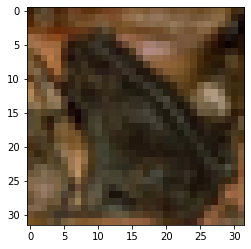

In [70]:
import matplotlib.pyplot as plt

plt.imshow(np.transpose(test_images[30], [1, 2, 0]))
plt.show()

In [73]:
test_labels[30]

6

In [75]:
test_predict_result[30]

[[6]]